# Trap definition
Towards more effective MOT loading, we wish to calculate atomic thermal distributions as a function of distance traveled in a slowing beam. Let's set up the experiment:

In [6]:
from MOTorNOT.beams import *
from MOTorNOT.coils import *
wavelength = 399e-9
wavenumber = 2*np.pi/wavelength
linewidth = 2*np.pi*29e6
state = {}
state['coil'] = {'radius': 0.08,
             'z': 0.08,
             'N': 50,
             'I': 55,
             'axis': 2
            }
coil = Coil(state['coil'])
from copy import deepcopy
state['coil2'] = deepcopy(state['coil'])
state['coil2']['I'] = -55
state['coil2']['z'] *= -1
coil2 = Coil(state['coil2'])
coils = Coils([coil, coil2])

state['beam'] = {'wavevector': wavenumber * np.array([-1,0,0]),
                 'power': 15e-3,
                 'radius': 2e-3,
                 'detuning': -linewidth/4,
                 'handedness': 1
                }

beam = Beam(state['beam'])
state['beam2'] = deepcopy(state['beam'])
state['beam2']['wavevector'] *= -1
beam2 = Beam(state['beam2'])

mot = Beams([beam, beam2], field=coils.field)
# mot.plot()


# from MOTorNOT.gmot import gratingMOT
# period = 600e-9        # 600 nm groove spacing
# wavelength = 399e-9    # 399 nm wavelength
# linewidth = 29e6

# mot = gratingMOT({'position': 3e-3, 
#                    'alpha': np.arcsin(wavelength/period), 
#                    'radius': 8e-3, 
#                    'field': coils.field, 
#                    'power': 20e-3, 
#                    'detuning': -linewidth/2, 
#                    'polarization': -1, 
#                    'R1': 0.33},
#                   show_incident=True,
#                   show_positive=True,
#                   show_negative=True
#                 )
# mot.plot()

/Users/robbiefasano/MOTorNOT/MOTorNOT/beams.py:31: RuntimeWarning: invalid value encountered in true_divide
  self.orth2 = self.orth2 /  np.linalg.norm(self.orth2)


# Phase-space analysis


In [2]:
def prepare_coordinates(x, v, axis, numpoints):
    ''' Converts 1D coordinates into full 3D coordinate arrays along the axis specified. '''
    X = np.zeros((numpoints, 3))
    V = np.zeros((numpoints, 3))
    X[:,axis] = x
    V[:,axis] = v
    return X, V

''' Identify trapped atoms '''
def get_trapped(x, v):
    x_trapped = x.copy()
    v_trapped = v.copy()

    N = int(len(x.columns)/3)
    threshold = 1e-3
    trapped = []
    for i in range(N):
        r = np.sqrt(x['x%i'%i]**2+x['y%i'%i]**2+x['z%i'%i]**2).iloc[-1]
        if r > threshold:
            x_trapped = x_trapped.drop(['x%i'%i, 'y%i'%i, 'z%i'%i],axis=1)
            v_trapped = v_trapped.drop(['vx%i'%i, 'vy%i'%i, 'vz%i'%i],axis=1)

    return x_trapped, v_trapped

Phase-space analysis helps to visualize the velocity capture range - all captured atoms are pulled to the phase-space origin.

6.5% done; estimated time remaining: 37 s                     

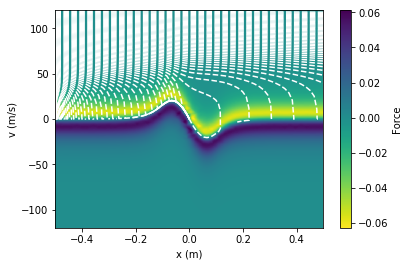

In [7]:
from MOTorNOT.parameters import *
from MOTorNOT.plotting import *

steps=50
# xmin = -5*state['coil1']['R']
xmin = -500e-3
xmax = -xmin
vmin = 5
vmax = 120
grid = []
vx = np.linspace(-vmax, vmax, steps)
x = np.linspace(xmin, -xmin, steps)
def cartesian(x, y):
    ''' Returns the cartesian product of two arrays '''
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
grid = cartesian(x, vx)

''' Plot force in phase-space '''
X, V = prepare_coordinates(grid[:,0], grid[:,1], 0, steps**2)
f=mot.force(X,V)[:,0]

# from emergent.pipeline.plotting import plot_2D
f_norm = f/constants['hbar']/atom['k']/atom['gamma']
p = plot_phase_space_force(grid, f_norm)
# plt.show()
''' Calculate trajectories '''
N = 100
X, V = prepare_coordinates(xmin, np.linspace(vmin, vmax, N), 0, N)
# theta = np.pi/4
# m = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0,0,1]])
# for i in range(len(V)):
#     V[i] = np.dot(m, V[i])
# for i in range(len(X)):
#     X[i] = np.dot(m, X[i])  
tmax = 5*np.abs(xmin)/V[:,0].min()

from MOTorNOT.integration import Solver
sol = Solver(X, V, mot.force, None, duration = tmax, dt=tmax/1000)
x, v = sol.solve()
# x, v = get_trapped(x, v)
plot_phase_space_trajectories(x, v, xlim=[xmin, xmax], ylim=[-vmax, vmax])

plt.xlim()
plt.ylim([-vmax, vmax])
plt.show()

In [8]:
x


,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,z96,x97,y97,z97,x98,y98,z98,x99,y99,z99
0.0000,-0.500000,0.0,0.0,-0.500000,0.0,0.0,-0.500000,0.0,0.0,-0.500000,...,0.0,-0.500000,0.0,0.0,-0.500000,0.0,0.0,-0.500000,0.0,0.0
0.0005,-0.499576,0.0,0.0,-0.499461,0.0,0.0,-0.499328,0.0,0.0,-0.499175,...,0.0,-0.441192,0.0,0.0,-0.440611,0.0,0.0,-0.440029,0.0,0.0
0.0010,-0.499559,0.0,0.0,-0.499444,0.0,0.0,-0.499311,0.0,0.0,-0.499158,...,0.0,-0.382446,0.0,0.0,-0.381281,0.0,0.0,-0.380116,0.0,0.0
0.0015,-0.499543,0.0,0.0,-0.499428,0.0,0.0,-0.499295,0.0,0.0,-0.499142,...,0.0,-0.323762,0.0,0.0,-0.322011,0.0,0.0,-0.320261,0.0,0.0
0.0020,-0.499527,0.0,0.0,-0.499412,0.0,0.0,-0.499279,0.0,0.0,-0.499126,...,0.0,-0.265139,0.0,0.0,-0.262802,0.0,0.0,-0.260465,0.0,0.0
0.0025,-0.499511,0.0,0.0,-0.499396,0.0,0.0,-0.499263,0.0,0.0,-0.499109,...,0.0,-0.206580,0.0,0.0,-0.203654,0.0,0.0,-0.200729,0.0,0.0
0.0030,-0.499495,0.0,0.0,-0.499380,0.0,0.0,-0.499247,0.0,0.0,-0.499093,...,0.0,-0.148087,0.0,0.0,-0.144570,0.0,0.0,-0.141054,0.0,0.0
0.0035,-0.499479,0.0,0.0,-0.499364,0.0,0.0,-0.499231,0.0,0.0,-0.499077,...,0.0,-0.089669,0.0,0.0,-0.085560,0.0,0.0,-0.081453,0.0,0.0
0.0040,-0.499463,0.0,0.0,-0.499348,0.0,0.0,-0.499215,0.0,0.0,-0.499061,...,0.0,-0.031350,0.0,0.0,-0.026648,0.0,0.0,-0.021947,0.0,0.0
0.0045,-0.499447,0.0,0.0,-0.499332,0.0,0.0,-0.499199,0.0,0.0,-0.499045,...,0.0,0.026879,0.0,0.0,0.032182,0.0,0.0,0.037482,0.0,0.0


# Estimating capture velocity
Since optical molasses is non-conservative, a potential cannot be uniquely defined for a MOT. However, we can define a potential associated only with the conservative magnetic restoring component, which can place pessimistic bounds on trapping capabilities. The potential is defined as the integral of the trapping force from the center of the trap to a point X at zero velocity.

Problem - MOTs aren't curl-free in general, so a path-independent potential can't be defined. Instead, we need to simulate atomic trajectories and devise a trapping criterion, i.e. checking for convergence to the phase-space minimum.

However, six-beam MOTs are (probably) approximately curl-free near the phase-space origin - one must neglect cross-derivatives arising from, for example, radiation pressure in one direction decreasing along another axis due to changes in beam intensity (which can be neglected for sufficiently uniform beams).

In [ ]:
import numdifftools as nd
import scipy as sp

def J_ij(f, x, i, j, step = 1e-5):
    ''' Calculates the derivative of the ith component of a vector function along axis j '''
    v = np.zeros((len(x),3))
    dx = np.zeros((len(x),3))
    dx[:][:,j] = step/2
    upper = f(X+dx, V)
    lower = f(X-dx, V)
    deriv = (upper-lower)/step
    return deriv[:, i]

# X = np.atleast_2d([[1e-3,0,0]])

X = np.atleast_2d([[1e-3,1e-3,0], [1e-3,0,1e-3]])
''' Check step size convergence '''
# perf = []
# for s in np.linspace(1e-4, 1e-1):
#     perf.append(J_ij(mot.force, X, 0, 0, s))
    
    
''' Calculate curl '''
def curl(f,x):
    jac = np.zeros((len(x),3,3))
    for i in range(3):
        for j in range(3):
            jac[:,i,j] = J_ij(f, x, i, j)
#     print(jac)
    return np.array([jac[:,2,1]-jac[:,1,2],jac[:,0,2]-jac[:,2,0],jac[:,1,0]-jac[:,0,1]]).T

curl(mot.force, X)
# d=J_ij(mot.force, X, 0,0)


In [ ]:
dx

In [ ]:
f

In [ ]:
X = np.atleast_2d([0,0,1e-3])
V = np.atleast_2d([0,0,0])
mot.force(X,V)

In [ ]:
''' Identify trapped atoms '''
def get_trapped(x, v):
    x_trapped = x.copy()
    v_trapped = v.copy()

    N = int(len(x.columns)/3)
    threshold = 1e-3
    trapped = []
    for i in range(N):
        r = np.sqrt(x['x%i'%i]**2+x['y%i'%i]**2+x['z%i'%i]**2).iloc[-1]
        if r > threshold:
            x_trapped = x_trapped.drop(['x%i'%i, 'y%i'%i, 'z%i'%i],axis=1)
            v_trapped = v_trapped.drop(['vx%i'%i, 'vy%i'%i, 'vz%i'%i],axis=1)

    return x_trapped, v_trapped
        
print(get_trapped(x,v))

In [ ]:
x_trapped = x.copy()
import pandas as pd
x_trapped.drop(['x0', 'y0', 'z0'], axis=1)